### Import libs

In [1]:
import os
import pandas as pd
import numpy as np

from torchvision import transforms

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from efficientnet_pytorch import EfficientNet

from sklearn.metrics import classification_report

from PIL import Image

import matplotlib.pyplot as plt

import random

### Prepare data

In [2]:
train_data_path = '../data/Training'
test_data_path = '../data/Testing'

In [3]:
def create_dataframe(data_path):
    filepaths = []
    labels = []
    folds = [fold for fold in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, fold))]
    for fold in folds:
        f_path = os.path.join(data_path, fold)
        if not os.path.isdir(f_path):
            continue
        filelists = os.listdir(f_path)
        for file in filelists:
            filepaths.append(os.path.join(f_path, file))
            labels.append(fold)
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='label')
    return pd.concat([Fseries, Lseries], axis=1)

train_df = create_dataframe(train_data_path)
test_df = create_dataframe(test_data_path)

# Создание словаря классов
class_names = train_df['label'].unique()
class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

# Преобразование меток в индексы
train_df['label'] = train_df['label'].map(class_to_idx)
test_df['label'] = test_df['label'].map(class_to_idx)


In [4]:
# Преобразования изображений
img_size = (224, 244)
batch_size = 16

train_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
])

In [5]:
# Перенос модели на GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Создание DataLoader'ов
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, label

train_dataset = CustomDataset(train_df, transform=train_transform)
test_dataset = CustomDataset(test_df, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Model architecture

In [7]:
class CustomEfficientNetB3(nn.Module):
    def __init__(self, num_classes):
        super(CustomEfficientNetB3, self).__init__()
        self.base_model = EfficientNet.from_pretrained('efficientnet-b3')
        self.pooling = nn.AdaptiveMaxPool2d(1)
        self.bn = nn.BatchNorm1d(self.base_model._fc.in_features, momentum=0.99, eps=0.001)
        self.fc1 = nn.Linear(self.base_model._fc.in_features, 256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.4)
        self.fc2 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = self.base_model.extract_features(x)
        x = self.pooling(x).squeeze(-1).squeeze(-1)
        x = self.bn(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


num_classes = 4  
model = CustomEfficientNetB3(num_classes).to(device)

Loaded pretrained weights for efficientnet-b3


### Model training and evaluate

In [8]:
# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
def evaluate_model(loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss = running_loss / len(loader)
    accuracy = correct / total
    return loss, accuracy

In [10]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)


num_epochs = 20

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    val_loss, val_accuracy = evaluate_model(test_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch [1/20], Train Loss: 0.4568, Train Accuracy: 0.8566, Val Loss: 0.6383, Val Accuracy: 0.8131
Epoch [2/20], Train Loss: 0.2492, Train Accuracy: 0.9245, Val Loss: 0.3649, Val Accuracy: 0.8696
Epoch [3/20], Train Loss: 0.3780, Train Accuracy: 0.8925, Val Loss: 0.8055, Val Accuracy: 0.7613
Epoch [4/20], Train Loss: 0.1868, Train Accuracy: 0.9433, Val Loss: 0.1565, Val Accuracy: 0.9497
Epoch [5/20], Train Loss: 0.1505, Train Accuracy: 0.9524, Val Loss: 0.1485, Val Accuracy: 0.9512
Epoch [6/20], Train Loss: 0.1346, Train Accuracy: 0.9599, Val Loss: 0.1487, Val Accuracy: 0.9580
Epoch [7/20], Train Loss: 0.1534, Train Accuracy: 0.9536, Val Loss: 0.1660, Val Accuracy: 0.9603
Epoch [8/20], Train Loss: 0.1606, Train Accuracy: 0.9554, Val Loss: 0.1059, Val Accuracy: 0.9741
Epoch [9/20], Train Loss: 0.1379, Train Accuracy: 0.9610, Val Loss: 0.1576, Val Accuracy: 0.9451
Epoch [10/20], Train Loss: 0.0873, Train Accuracy: 0.9744, Val Loss: 0.1385, Val Accuracy: 0.9603
Epoch [11/20], Train Loss: 0.



### Chart training

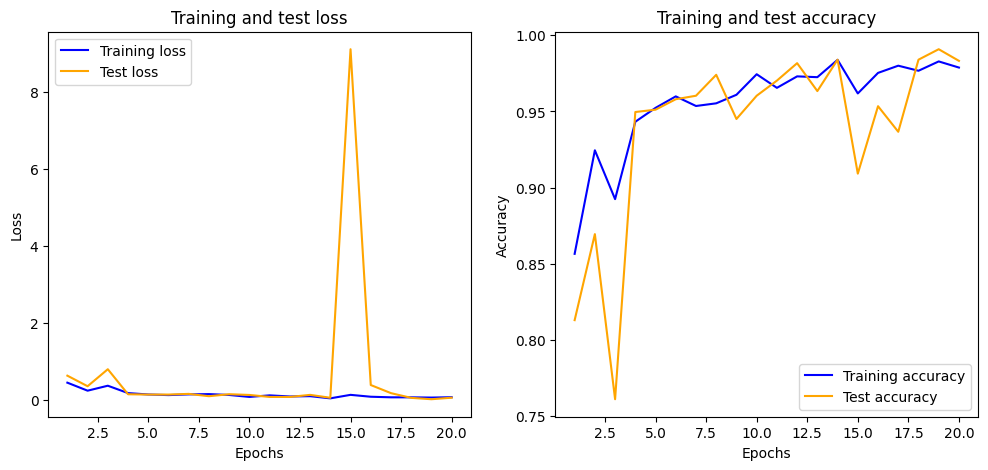

In [21]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training loss', color='blue')
plt.plot(epochs, val_losses, label='Test loss', color='orange')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training accuracy', color='blue')
plt.plot(epochs, val_accuracies, label='Test accuracy', color='orange')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [14]:
# Оценка модели на тестовом наборе данных
test_loss, test_accuracy = evaluate_model(test_loader)

print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_accuracy)

Test Loss:  0.0671759841456159
Test Accuracy:  0.9832189168573608


### Prediction

In [15]:
# Генерация предсказаний на тестовом наборе
def generate_predictions(loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

y_pred, y_true = generate_predictions(test_loader)
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   pituitary       0.98      0.99      0.99       300
     notumor       0.99      1.00      0.99       405
  meningioma       0.98      0.96      0.97       306
      glioma       0.97      0.99      0.98       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



### Save model

In [23]:
torch.save(model.state_dict(), 'model_pytorch.pth')